# Test feedback (order 2) and sensitivity to model errors

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from copy import deepcopy

import cognac.float as fl

--- 
## Instantiate water and float object

WOA water profile at lon=6, lat=40


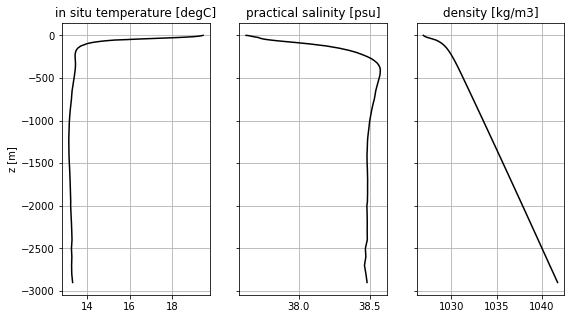

In [2]:
# select a water profile
#w = fl.waterp(lon=-50.,lat=40.) # Gulf Stream
w = fl.waterp(lon=6.,lat=40.) # Mediterranean sea

if False:
    root_dir = '/Users/aponte/Current_projects/cognac/tests/202006_ifremer/data/bassin1_bags/'
    cast = pd.read_csv(root_dir+'profil.csv', names=['depth', 'salinity', 'temperature'], skiprows=2)
    cast['depth'] = cast['depth']/1e2
    #cast['salinity'] = 37 # sans sel
    #cast['temperature'] = 14 # sans température
    w = fl.waterp(pressure=cast['depth'], temperature=cast['temperature'], salinity=cast['salinity'], lon=6.,lat=40.)

print(w)

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-500.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = fl.autonomous_float(model='Ifremer')
f.init_piston()
print(f)

# adjust mass to be at equilibrium at 0m and substract 5g
iz = np.argmin(np.abs(z+0))
f.adjust_m(p[iz],temp[iz],rho_w[iz], offset=-5)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

Piston max volume set from max displacement
Float parameters: 
  L     = 0.83 m      - float length
  r     = 0.07 m      - float radius
  m     = 11.63 kg     - float mass
  V     = 1.27e+04 cm^3   - float volume
  rho_cte = m/V = 9.13e+08 kg.cm^3   - float baseline density
  gamma = 3.78e-06 /dbar  - mechanical compressibility
  gamma x V = 4.82e-02 cm^3/dbar  - normalized compressibility
  alpha = 6.98e-05 /degC  - thermal compressibility
  alpha x V = 8.89e-01 cm^3/degC  - normalized thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 0.97 cm        - piston radius
  d     = 0.00 cm        - present piston displacement
  vol   = 26.88 cm^3      - present volume addition
  d_increment  = 8.57e-02 mm        - smallest variation of translation motion for the p

In [4]:
# adjust piston to be at equilibrium -1m
z0 = -1.
iz = np.argmin(np.abs(z-z0))
vstart = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) ) # check

Piston reset for equilibrium : vol=2.2e+01 cm^3  
z equilibrium = -1.0m


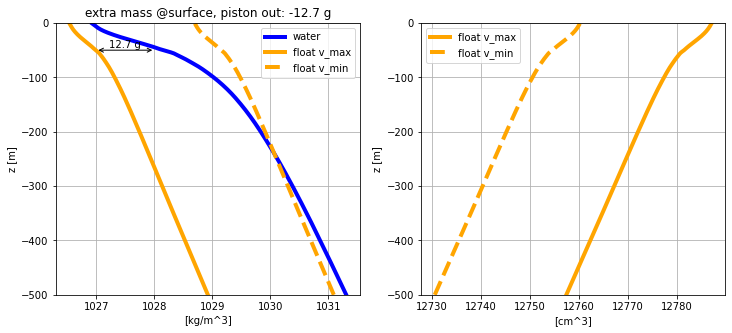

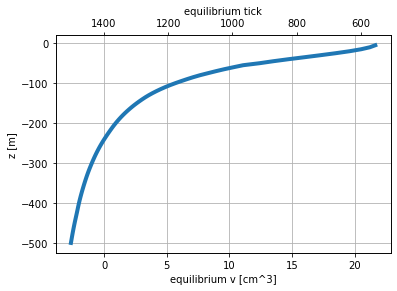

In [5]:
# show densities
fig, ax = plt.subplots(1, 2, figsize=(12,5))
fl.plot_float_density(z, f, w, ax=ax[0])
fl.plot_float_volume(z, f, w, ax=ax[1])

_ = fl.plot_equilibrium_volume(f, w, zlim=(z.min(),0))

---

### set up desired trajectory

In [6]:
# we start by constructing a trajectory that can be followed by the float
target_velocity = .1

#z_target = fl.descent(3600, -100., wmax=target_velocity, zstart=z0)
#Tsim = 2700.

z_target = fl.descent(3600, -5., wmax=10., zstart=z0)
Tsim = 500.

In [7]:
f0 = deepcopy(f)

---

### second order relaxation, NO kalman

Start time stepping for 8 min ...
... time stepping done
Extrapolated energy conssumption: 9.6e-04 Wh/day = 0.0 Wh/30day


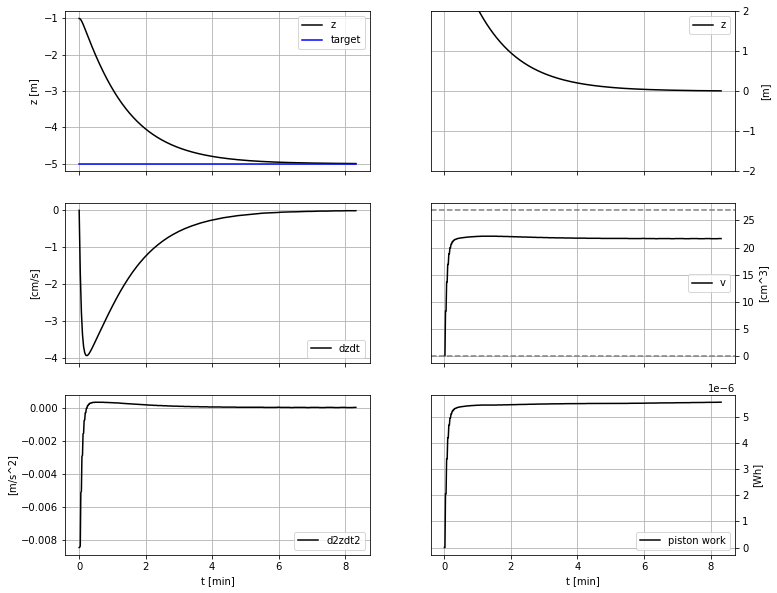

In [8]:
# control parameters
_c = {'mode': 'feedback2', 'dt': 2., 'dz_nochattering': 0.,
      'nu': target_velocity*2./np.pi, 'tau': 10., 'delta': 5.,
      'continuous': False}

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, verbose=0)
f.plot_logs(z_target=z_target)
log0 = f.log

In [9]:
_ = f.log['control'].plot_bk()

Loading BokehJS ...

### perturb knowledge of some variables:

- mass x 0.5, mass x 3, mass x 5
- drag x 0.5, drag x 2
- acceleration: add constant offset

Start time stepping for 8 min ...
... time stepping done
Start time stepping for 8 min ...
... time stepping done
Extrapolated energy conssumption: 9.6e-04 Wh/day = 0.0 Wh/30day


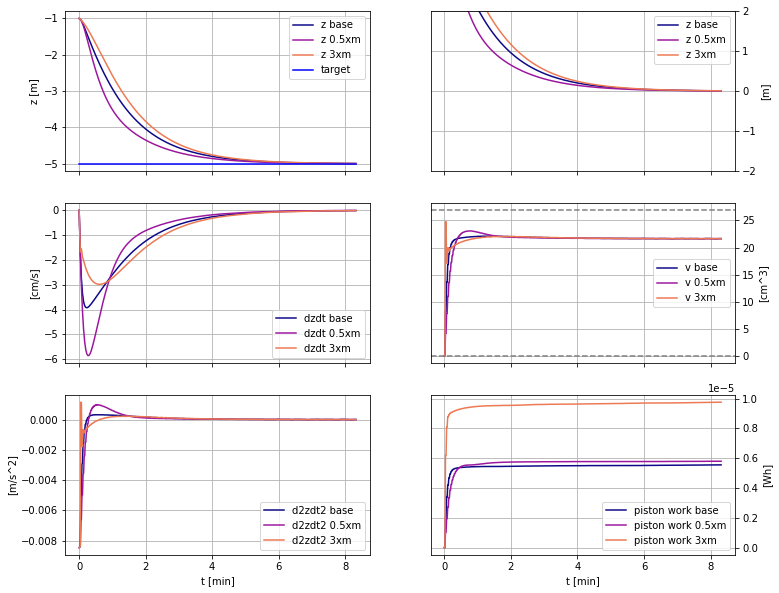

In [10]:
scale = 0.5

_c['m'] = f.m*scale
f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, verbose=0)
logs = {'base': log0, '{}xm'.format(scale): f.log}

scale = 3
_c['m'] = f.m*scale
f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, verbose=0)
logs['{}xm'.format(scale)] = f.log

fl.log.plot_logs(logs, f, z_target=z_target)

Start time stepping for 8 min ...
... time stepping done
Extrapolated energy conssumption: 9.6e-04 Wh/day = 0.0 Wh/30day


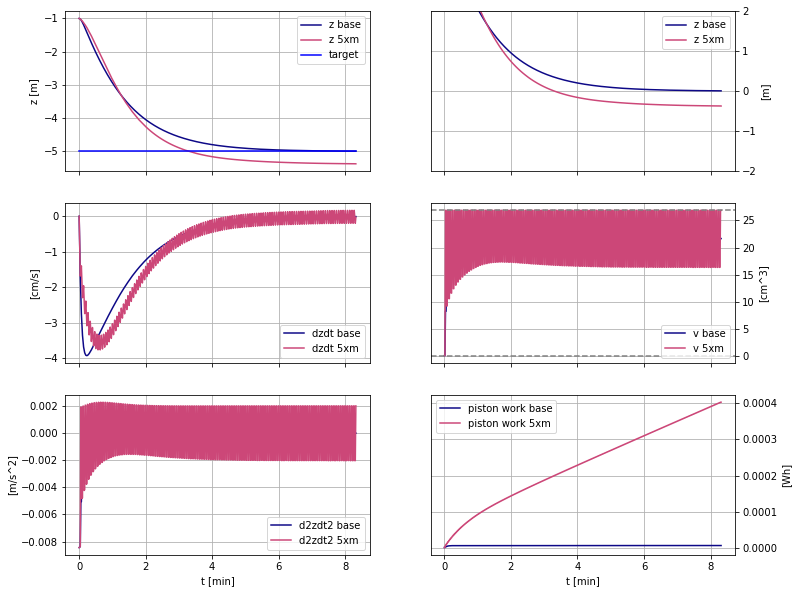

In [11]:
scale = 5
_c['m'] = f.m*scale
f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, verbose=0)
fl.log.plot_logs({'base': log0, '{}xm'.format(scale): f.log}, f, z_target=z_target)

In [12]:
# reset right mass
_c['m'] = f.m
# stotre initial drag
Lv0 = f.Lv

Start time stepping for 8 min ...
... time stepping done
Start time stepping for 8 min ...
... time stepping done
Extrapolated energy conssumption: 9.6e-04 Wh/day = 0.0 Wh/30day


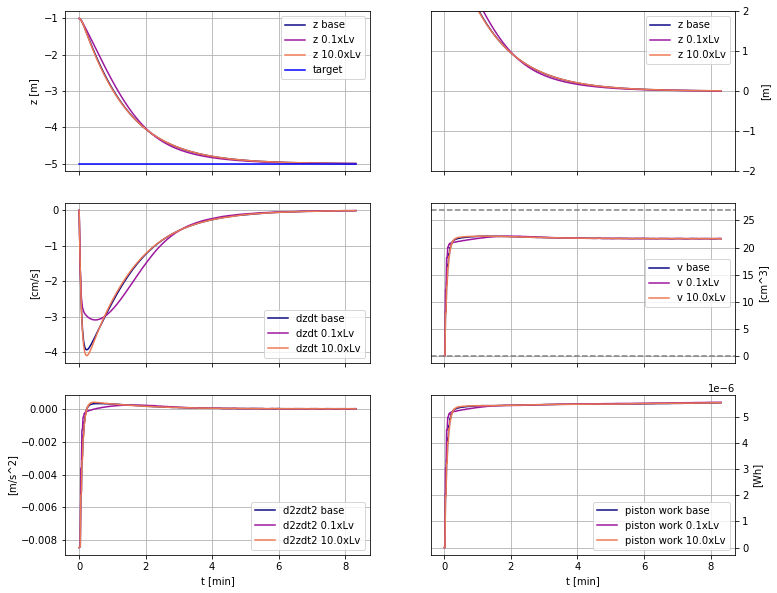

In [13]:
scale = 0.1
_c['Lv'] = Lv0*scale
f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, verbose=0)
logs = {'base': log0, '{}xLv'.format(scale): f.log}

#
scale = 10.
_c['Lv'] = Lv0*scale
f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, verbose=0)
logs['{}xLv'.format(scale)] = f.log

fl.log.plot_logs(logs, f, z_target=z_target)

In [14]:
# reset Lv
_c['Lv'] = Lv0

Start time stepping for 8 min ...
... time stepping done
Extrapolated energy conssumption: 9.6e-04 Wh/day = 0.0 Wh/30day


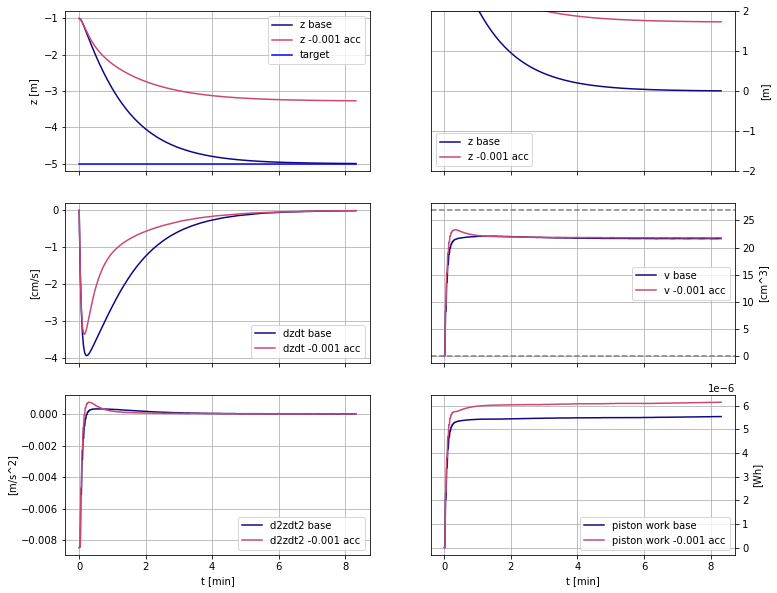

In [15]:
# perturb acceleration with a constant value
scale = -1e-3
_c['perturbation'] = scale
f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, verbose=0)
logs = {'base': log0, '{} acc'.format(scale): f.log}

fl.log.plot_logs(logs, f, z_target=z_target)

---

### first order relaxation, NO kalman

Perturb:
- mass x 0.5, mass x 3, mass x 5
- drag x 0.5, drag x 2
- equivalent volume: add constant offset

Start time stepping for 8 min ...
... time stepping done
Extrapolated energy conssumption: 1.1e-03 Wh/day = 0.0 Wh/30day


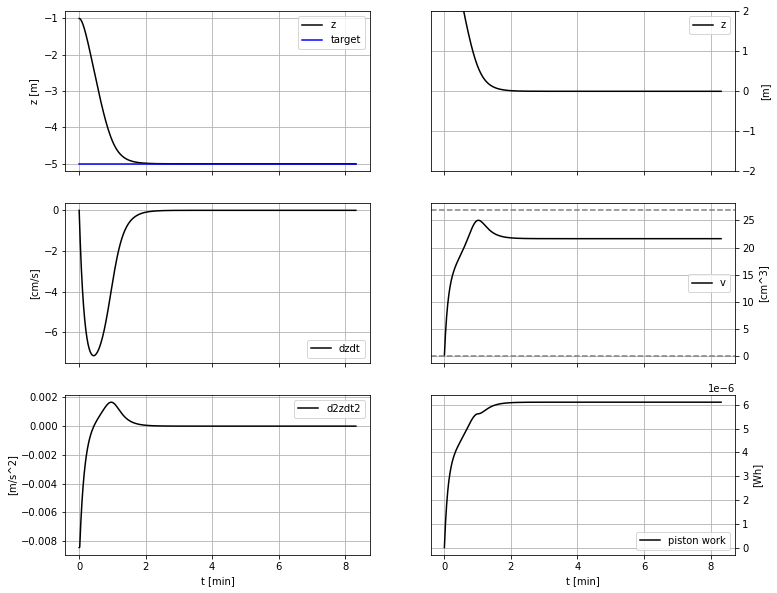

In [16]:
# control parameters
_c = {'mode': 'feedback1', 'dt': 1., 'dz_nochattering': 0.,
      'nu': target_velocity*2./np.pi, 'tau': 10., 'delta': 1.,
      'gammaV': 0.,
      'continuous': False}

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, verbose=0)
f.plot_logs(z_target=z_target)
log0 = f.log

Start time stepping for 8 min ...
... time stepping done
Start time stepping for 8 min ...
... time stepping done
Extrapolated energy conssumption: 1.1e-03 Wh/day = 0.0 Wh/30day


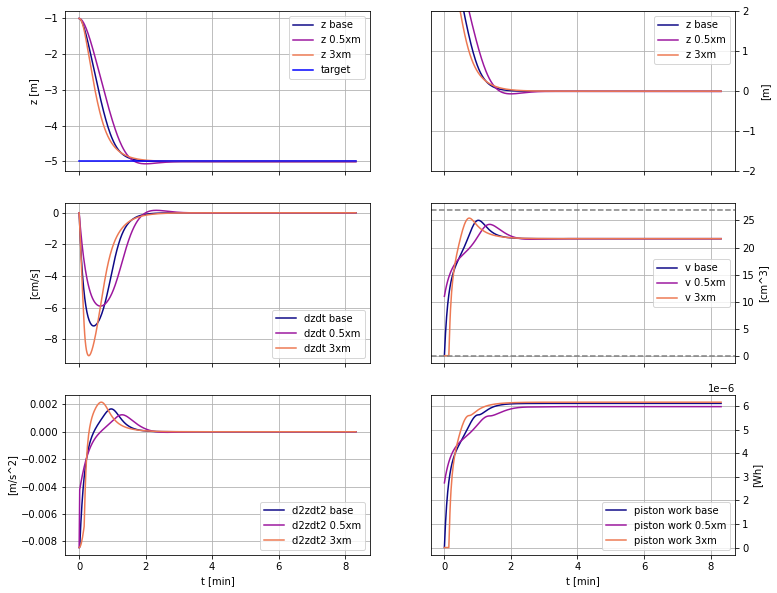

In [17]:
scale = 0.5

_c['m'] = f.m*scale
f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, verbose=0)
logs = {'base': log0, '{}xm'.format(scale): f.log}

scale = 3
_c['m'] = f.m*scale
f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, verbose=0)
logs['{}xm'.format(scale)] = f.log

fl.log.plot_logs(logs, f, z_target=z_target)

In [18]:
# reset right mass
_c['m'] = f.m
# stotre initial drag
Lv0 = f.Lv

Start time stepping for 8 min ...
... time stepping done
Start time stepping for 8 min ...
... time stepping done
Extrapolated energy conssumption: 1.1e-03 Wh/day = 0.0 Wh/30day


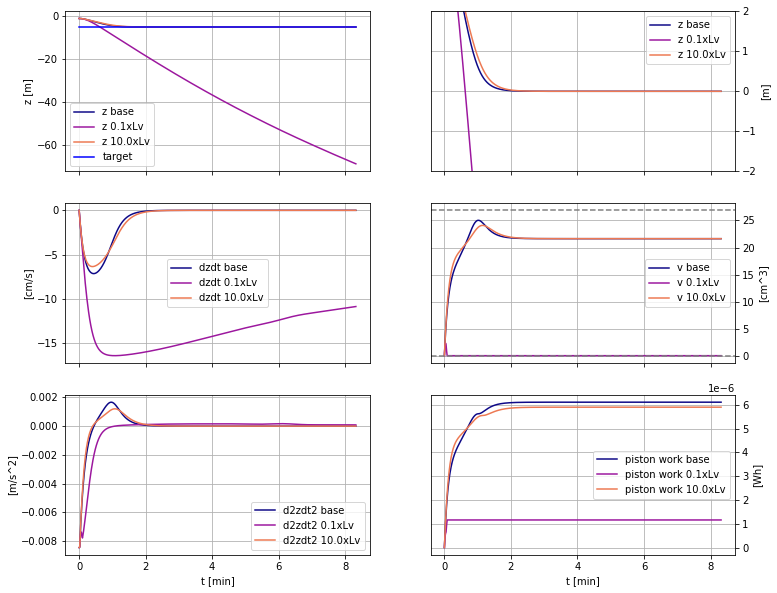

In [19]:
scale = 0.1
_c['Lv'] = Lv0*scale
f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, verbose=0)
logs = {'base': log0, '{}xLv'.format(scale): f.log}

#
scale = 10.
_c['Lv'] = Lv0*scale
f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, verbose=0)
logs['{}xLv'.format(scale)] = f.log

fl.log.plot_logs(logs, f, z_target=z_target)

In [20]:
# reset Lv
_c['Lv'] = Lv0

Start time stepping for 8 min ...
... time stepping done
Extrapolated energy conssumption: 1.1e-03 Wh/day = 0.0 Wh/30day


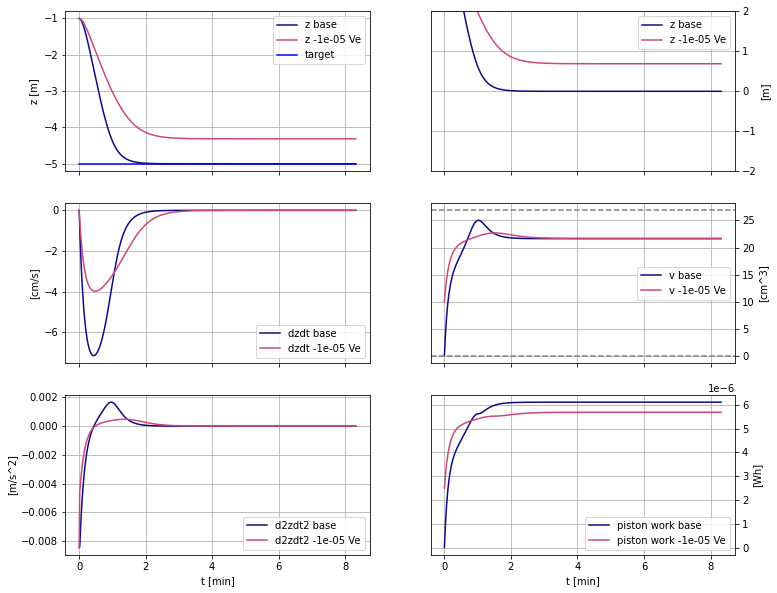

In [21]:
# perturb V_e
scale = -1e-5
_c['perturbation'] = scale
f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, verbose=0)
logs = {'base': log0, '{} Ve'.format(scale): f.log}

fl.log.plot_logs(logs, f, z_target=z_target)